In [1]:
import numpy as np
import math
# Importing standard Qiskit libraries

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
import qiskit as qk
# Loading your IBM Quantum account(s)

provider = IBMQ.load_account()

In [2]:
#Function that convert integers numbers in binary from a list
def binaryVector(vectorNumbers):
    binaryVector = []
    lengthBits = 0
    binary = bin(max(vectorNumbers))
    bin_string = str(binary)
    clean_binary = bin_string[2:len(bin_string)]
    lengthBits = len(clean_binary) 
    
    for index in range(0,len(vectorNumbers)):
        binary = bin(vectorNumbers[index])
        bin_string = str(binary)
        clean_binary = bin_string[2:len(bin_string)]
        totalBinary = stringComplete(lengthBits,clean_binary)
        binaryVector.append(totalBinary)
    return binaryVector

In [3]:
#Function that complete a String from m bits in length 
def stringComplete(longValue,strignValue):
    resta = longValue - len(strignValue)
    Ceros = ''
    if resta !=0:
        for i in range(0,resta):
            Ceros += '0'      
    return Ceros+strignValue

In [4]:
#QRam
#Function that make a QRam memory from each number in a memory cell adress.
def qRam(binaryVector,qubitsPosition,qubitsBinaryRepresentation):
    nQubits=qubitsBinaryRepresentation+qubitsPosition
    qc = QuantumCircuit(nQubits)
    #Storage the multicontroler list with the index of each vectors' numbers
    listaMultiToffoli =[]
    for i in range(qubitsBinaryRepresentation,qubitsPosition+qubitsBinaryRepresentation):
        listaMultiToffoli.append(i)
    #Binary representation of each number of the vector in the corresponding index      
    for listaIndx in range(0,len(binaryVector)):
        binarioLista = binaryVector[listaIndx]  
        binarioIndexLista = bin(listaIndx)
        binarioIndexString = str(binarioIndexLista)
        binarioIndex = binarioIndexString[2:len(binarioIndexString)]
        valorBinario = stringComplete(qubitsPosition,binarioIndex)        
        for idx, px_value in enumerate(valorBinario[::-1]):
            if(px_value=='0'):
                qc.x(idx+qubitsBinaryRepresentation)
        for idx, px_value in enumerate(binarioLista[::-1]):
            if(px_value=='1'):
                qc.mct(listaMultiToffoli,idx)
        for idx, px_value in enumerate(valorBinario[::-1]):
            if(px_value=='0'):
                qc.x(idx+qubitsBinaryRepresentation)           
        U_s = qc.to_gate()
        U_s.name = "QRam"
        
    return U_s

In [5]:
#Outputs-Oracle
#Function that make the required outputs and gives the oracle
def oracle(outDesired,qubitsBinaryRepresentation):
    nQubits=qubitsBinaryRepresentation+outDesired
    qc = QuantumCircuit(nQubits)
    #Do multi-controlled-Toffoli gate
    multiToffoliBinaries = []
    for i in range(outDesired,outDesired+qubitsBinaryRepresentation):
        multiToffoliBinaries.append(i)
    #Encode Out1 all non-adjacent bits zero
    for idx in range(outDesired,outDesired+qubitsBinaryRepresentation):
        if(idx%2 == 0):
            qc.x(idx)
    #Apply multi-controlled-Toffoli gate to out0          
    qc.mct(multiToffoliBinaries,0)
    #Decode Out1 all non-adjacent bits zero
    for idx in range(outDesired,outDesired+qubitsBinaryRepresentation):
        if(idx%2 == 0):
            qc.x(idx)
    #Encode Out2 all non-adjacent bits one
    for idx in range(outDesired,outDesired+qubitsBinaryRepresentation):
        if(idx%2 != 0):
            qc.x(idx)            
    #Apply multi-controlled-Toffoli gate to out1                         
    qc.mct(multiToffoliBinaries,1)       
    #Decode Out2 all non-adjacent bits zero
    for idx in range(outDesired,outDesired+qubitsBinaryRepresentation):
        if(idx%2 != 0):
            qc.x(idx)
    U_s = qc.to_gate()
    U_s.name = "Oracle"        
    return U_s

In [6]:
#Grover implementation (diffuser)
def grover(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    if(nqubits>=2):
        qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    else:
        qc.x(nqubits-1)
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "Grover"
    return U_s

In [7]:
#Function to build the quantum circuit from Task 1
def circuitTaskOne(binaryVector):
#  outDesired = 2 (required Qubits for the both results) int
#  qubitsPosition = (required Qubits for vector indices) int
#  qubitsBinaryRepresentation = (m bits in length) int
    outDesired = 2
    qubitsPosition = int(math.log(len(vector),2))
    qubitsBinaryRepresentation = len(binaryVector[0])
    # named qubits
    out = QuantumRegister(outDesired,'out')
    binary = QuantumRegister(qubitsBinaryRepresentation,'binary')
    index = QuantumRegister(qubitsPosition, 'idex')
    # classical register
    cr = ClassicalRegister(qubitsPosition,'cr')
    # create the quantum circuit
    qc = QuantumCircuit(out,binary,index,cr)
    # set the total number of qubits
    num_qubits = qc.num_qubits
    # set multicontrol toffoli difusser
    multicontrolerDiffuser = []
    init = num_qubits-qubitsPosition
    for idx in range(init,num_qubits):
        multicontrolerDiffuser.append(idx)
    
    #Superposition property for the indices to storage the vector's numbers
    for index in range(outDesired+qubitsBinaryRepresentation,num_qubits):
        qc.h(index)
    qc.append(qRam(binaryVector,qubitsPosition,qubitsBinaryRepresentation),range(outDesired,num_qubits))
    qc.append(oracle(outDesired,qubitsBinaryRepresentation),range(0,outDesired+qubitsBinaryRepresentation))
    qc.append(qRam(binaryVector,qubitsPosition,qubitsBinaryRepresentation),range(outDesired,num_qubits))
    qc.append(grover(qubitsPosition), multicontrolerDiffuser)
    qc.measure(range(qubitsBinaryRepresentation+outDesired,num_qubits),range(qubitsPosition))
    

    return qc

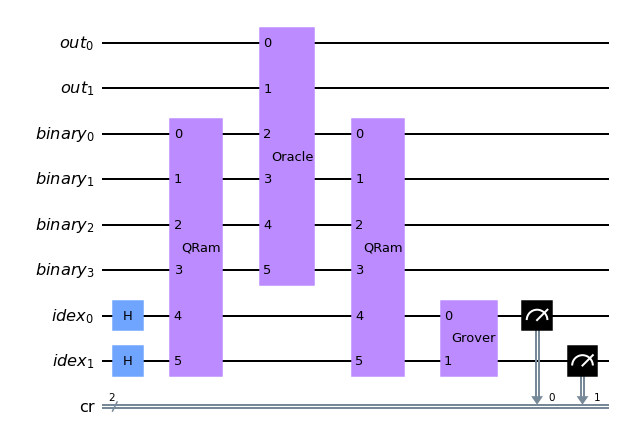

In [8]:
vector = [1,5,7,10]

if math.log(len(vector),2) % 2 == 0 and len(vector)>1 or len(vector)==2:
    qc_Task = circuitTaskOne(binaryVector(vector))
else:
    print("please define a vector size 2^n")
qc_Task.draw(output='mpl')

{'11': 380, '01': 372, '00': 141, '10': 107}


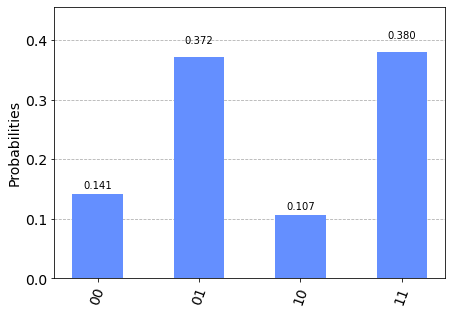

In [9]:
aer_sim = Aer.get_backend('qasm_simulator')
t_qc_image = transpile(circuitTaskOne(binaryVector(vector)), aer_sim)
qobj = qk.assemble(t_qc_image, shots=1000)
job_neqr = aer_sim.run(qobj)
result_neqr = job_neqr.result()
counts_neqr = result_neqr.get_counts()

print(counts_neqr)
plot_histogram(counts_neqr)